# Residual Connection을 통한 Vanishing Gradient 완화 실습

이번 실습에서는 **Residual Connection (ResNet)** 이 깊은 신경망에서 발생하는 **Vanishing Gradient 문제**를 어떻게 완화하는지 비교합니다.

- Plain Deep Network (Residual 없음)
- Residual Network (Residual Block 포함)

두 모델을 동일한 데이터셋에서 학습시켜 성능을 비교합니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras.testing_utils import saved_model_format_scope

## 1. 데이터 준비

In [3]:
X, y = make_moons(n_samples=2000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 2. Plain Deep Network 정의 (Residual 없음)

In [4]:
def build_deep_plain(layers=20, units=64):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(2,)))
    for _ in range(layers):
        model.add(tf.keras.layers.Dense(units, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

## 3. Residual Block 정의

In [5]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(units, activation="relu")
        self.dense2 = tf.keras.layers.Dense(units, activation=None)
        self.activation = tf.keras.layers.Activation("relu")

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.activation(x + inputs)

## 4. Residual Network 정의

In [6]:
def build_residual_network(blocks=10, units=64):
    inputs = tf.keras.Input(shape=(2,))
    x = tf.keras.layers.Dense(units, activation="relu")(inputs)
    for _ in range(blocks):
        x = ResidualBlock(units)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

## 5. 모델 학습 (Plain vs Residual)

In [7]:
plain_model = build_deep_plain(layers=40, units=64)
history_plain = plain_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                                epochs=30, batch_size=32, verbose=0)

res_model = build_residual_network(blocks=10, units=64)
history_res = res_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=30, batch_size=32, verbose=0)

I0000 00:00:1758707544.524655    9837 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-09-24 18:52:28.393269: I external/local_xla/xla/service/service.cc:163] XLA service 0x7e7b500036f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-24 18:52:28.393312: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-09-24 18:52:28.486275: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-24 18:52:29.365909: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
I0000 00:00:1758707550.928815   10017 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at mos

## 6. 결과 비교 시각화

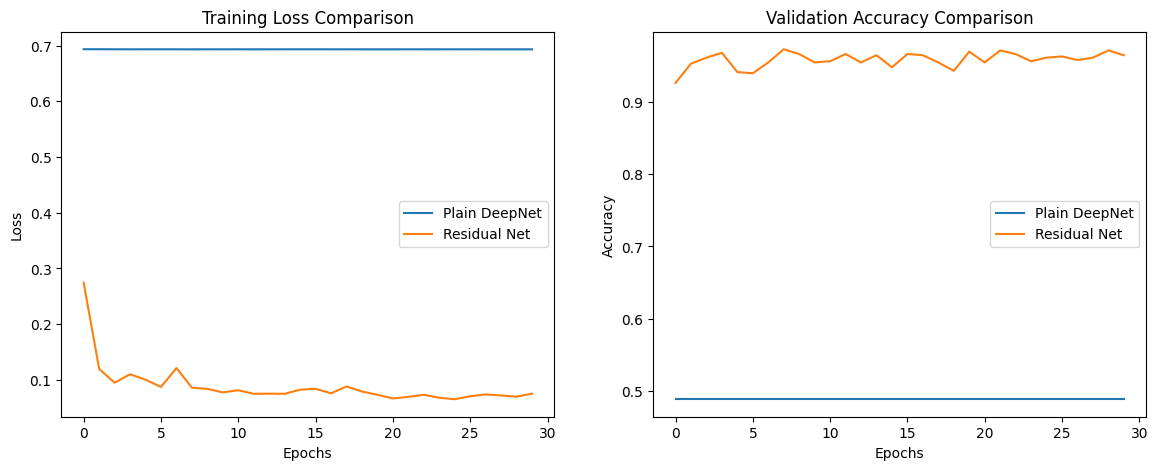

In [8]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_plain.history["loss"], label="Plain DeepNet")
plt.plot(history_res.history["loss"], label="Residual Net")
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_plain.history["val_accuracy"], label="Plain DeepNet")
plt.plot(history_res.history["val_accuracy"], label="Residual Net")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### 7. 생각해보기
- Layer의 수를 20에서 40으로 증가시켜보자. Plain Deep Network와 Residual Network의 성능 차이는 어떻게 변하는가?

Plain Deep Net 기울기를 소실하여 Loss가 수렴하지 않는다 즉 최적화가 일어지지 않는다 그럼으로 모델의 정확도도 올라가지 않는다.